In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/data 8.1", # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(200,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=25, # размер пакета (батча)
)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


In [3]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

In [4]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

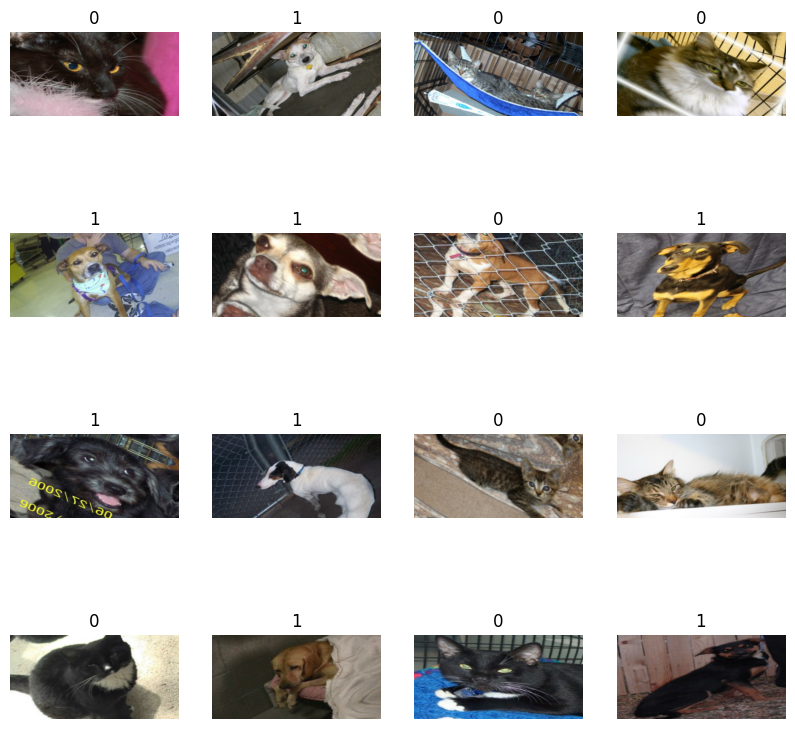

In [5]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 16 картинок из батча
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [6]:
# входной слой - размер (200, 400, 3)
inputs = tf.keras.Input(shape=(200, 400, 3))
# преобразуем значения пикселей из [0, 255] к [0, 1]
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same")(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
x = tf.keras.layers.Conv2D(128, 4, strides=2, padding="same")(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
x = tf.keras.layers.Conv2D(64, 4, strides=2, padding="same")(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# выпрямляем многомерный массив
x = tf.keras.layers.Flatten()(x)
# полносвязный слой с 64 нейронами
x = tf.keras.layers.Dense(64, activation="relu")(x)
# выходной слой с функцией sofrmax
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 400, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 200, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 100, 64)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 50, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 25, 128)       0         
 g2D)                                                        

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [9]:
model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
64/64 [==============================] - 34s 510ms/step - loss: 0.7019 - accuracy: 0.5387 - val_loss: 0.6176 - val_accuracy: 0.6500
Epoch 2/20
64/64 [==============================] - 26s 397ms/step - loss: 0.6651 - accuracy: 0.5975 - val_loss: 0.6548 - val_accuracy: 0.6450
Epoch 3/20
64/64 [==============================] - 28s 433ms/step - loss: 0.6344 - accuracy: 0.6406 - val_loss: 0.6279 - val_accuracy: 0.6575
Epoch 4/20
64/64 [==============================] - 31s 475ms/step - loss: 0.6224 - accuracy: 0.6669 - val_loss: 0.5801 - val_accuracy: 0.6600
Epoch 5/20
64/64 [==============================] - 32s 495ms/step - loss: 0.6302 - accuracy: 0.6550 - val_loss: 0.6055 - val_accuracy: 0.6600
Epoch 6/20
64/64 [==============================] - 30s 467ms/step - loss: 0.6015 - accuracy: 0.6994 - val_loss: 0.5569 - val_accuracy: 0.7125
Epoch 7/20
64/64 [==============================] - 30s 458ms/step - loss: 0.5758 - accuracy: 0.7038 - val_loss: 0.5703 - val_accuracy: 0.6800

In [10]:
predictions = [np.argmax(pred) for pred in model.predict(test_ds)]

16/16 [==============================] - 1s 87ms/step


In [11]:
y_test = np.empty(400)
j=0;
for images, labels in test_ds.take(16):
    for i in range(25):
        y_test[j+i] = int(labels[i])
    j+=25
print(j)

400


In [12]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.54      0.66       182
         1.0       0.71      0.92      0.80       218

    accuracy                           0.75       400
   macro avg       0.78      0.73      0.73       400
weighted avg       0.77      0.75      0.74       400

[[ 99  83]
 [ 17 201]]


# Задание 2

## VGG19

In [13]:
# формируем датасет
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/data 8.2", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(224,224), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=25, # размер пакета (батча)
)

Found 167 files belonging to 3 classes.
Using 142 files for training.
Using 25 files for validation.


In [14]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

In [15]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

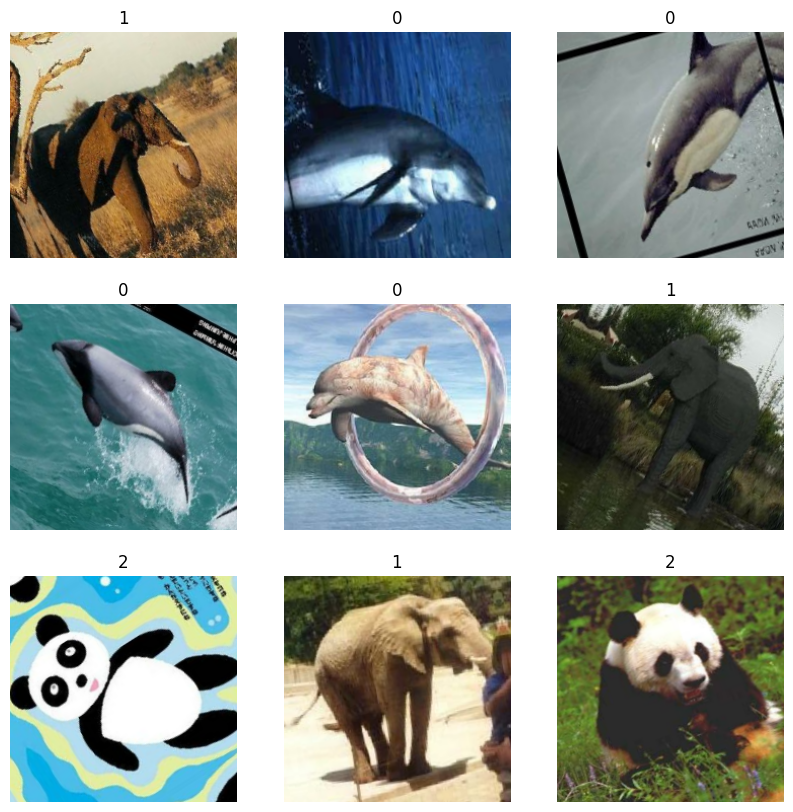

In [16]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [17]:
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
# сохраним ссылку на входной слой сети
inp = vgg.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой VGG и наш новый слой классификации
out = new_classification_layer(vgg.layers[-2].output)

# создадим новую модель
model_new = tf.keras.Model(inp, out)

In [19]:
model_new.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [20]:
for layer in model_new.layers:
    layer.trainable = False
model_new.layers[-1].trainable = True
model_new.layers[-2].trainable = True

In [21]:
model_new.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [22]:
model_new.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
6/6 [==============================] - 17s 3s/step - loss: 0.8664 - accuracy: 0.8310 - val_loss: 2.2851 - val_accuracy: 0.9200
Epoch 2/10
6/6 [==============================] - 17s 3s/step - loss: 0.2267 - accuracy: 0.9859 - val_loss: 3.7944 - val_accuracy: 0.9600
Epoch 3/10
6/6 [==============================] - 17s 3s/step - loss: 0.2483 - accuracy: 0.9859 - val_loss: 3.6555 - val_accuracy: 0.8800
Epoch 4/10
6/6 [==============================] - 16s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 6.1934 - val_accuracy: 0.9200
Epoch 5/10
6/6 [==============================] - 17s 3s/step - loss: 0.0782 - accuracy: 0.9930 - val_loss: 7.0989 - val_accuracy: 0.8800
Epoch 6/10
6/6 [==============================] - 17s 3s/step - loss: 0.2444 - accuracy: 0.9930 - val_loss: 7.3978 - val_accuracy: 0.8800
Epoch 7/10
6/6 [==============================] - 16s 3s/step - loss: 1.2249 - accuracy: 0.9789 - val_loss: 12.8228 - val_accuracy: 0.9600
Epoch 8/10
6/6 [=============

In [23]:
y_test = np.empty(25)
for images, labels in test_ds.take(1):
    for i in range(25):
        y_test[i] = int(labels[i])

In [24]:
predictions = [np.argmax(pred) for pred in model_new.predict(test_ds)]

1/1 [==============================] - 2s 2s/step


In [25]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93         7
         1.0       1.00      0.91      0.95        11
         2.0       1.00      1.00      1.00         7

    accuracy                           0.96        25
   macro avg       0.96      0.97      0.96        25
weighted avg       0.96      0.96      0.96        25

[[ 7  0  0]
 [ 1 10  0]
 [ 0  0  7]]


## InceptionV3

In [26]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/data 8.2", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(299,299), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=25, # размер пакета (батча)
)

Found 167 files belonging to 3 classes.
Using 142 files for training.
Using 25 files for validation.


In [27]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

In [28]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

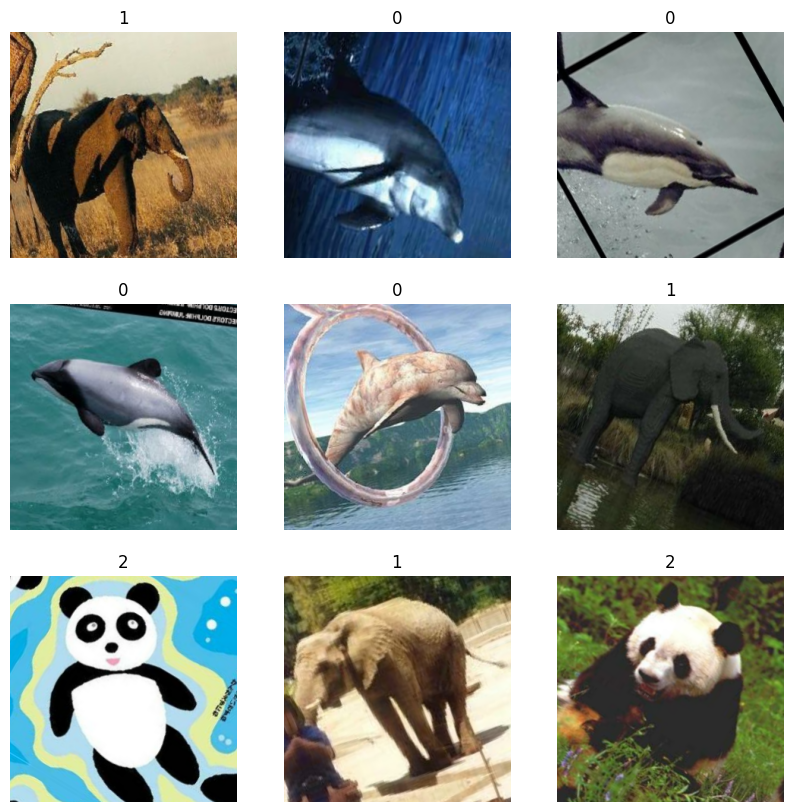

In [29]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [30]:
inc = tf.keras.applications.InceptionV3(weights='imagenet', include_top=True)
inc.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d_3[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalizati

In [31]:
# сохраним ссылку на входной слой сети
inp = inc.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой и наш новый слой классификации
out = new_classification_layer(inc.layers[-2].output)

# создадим новую модель
model_new2 = tf.keras.Model(inp, out)

In [32]:
model_new2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d_3[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0]

In [33]:
for layer in model_new2.layers:
    layer.trainable = False
model_new2.layers[-1].trainable = True
model_new2.layers[-2].trainable = True

In [34]:
model_new2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d_3[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0]

In [35]:
model_new2.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
6/6 [==============================] - 13s 2s/step - loss: 11.9924 - accuracy: 0.3310 - val_loss: 6.8820 - val_accuracy: 0.5200
Epoch 2/10
6/6 [==============================] - 8s 1s/step - loss: 7.7919 - accuracy: 0.3803 - val_loss: 4.9523 - val_accuracy: 0.5200
Epoch 3/10
6/6 [==============================] - 7s 1s/step - loss: 4.7232 - accuracy: 0.5000 - val_loss: 2.7861 - val_accuracy: 0.5200
Epoch 4/10
6/6 [==============================] - 7s 1s/step - loss: 3.2666 - accuracy: 0.6338 - val_loss: 4.0094 - val_accuracy: 0.6400
Epoch 5/10
6/6 [==============================] - 7s 1s/step - loss: 2.8921 - accuracy: 0.6901 - val_loss: 2.4738 - val_accuracy: 0.6800
Epoch 6/10
6/6 [==============================] - 7s 1s/step - loss: 2.1737 - accuracy: 0.6620 - val_loss: 2.6830 - val_accuracy: 0.6800
Epoch 7/10
6/6 [==============================] - 9s 2s/step - loss: 2.5916 - accuracy: 0.7042 - val_loss: 2.7429 - val_accuracy: 0.6000
Epoch 8/10
6/6 [=======================

In [36]:
y_test = np.empty(25)
for images, labels in test_ds.take(1):
    for i in range(25):
        y_test[i] = int(labels[i])

In [37]:
predictions = [np.argmax(pred) for pred in model_new2.predict(test_ds)]

1/1 [==============================] - 2s 2s/step


In [38]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.67      0.57      0.62         7
         1.0       0.64      0.82      0.72        11
         2.0       0.60      0.43      0.50         7

    accuracy                           0.64        25
   macro avg       0.64      0.61      0.61        25
weighted avg       0.64      0.64      0.63        25

[[4 2 1]
 [1 9 1]
 [1 3 3]]
